***Syntax natürlicher Sprachen, WS 2021/22***

---
# Übung 10

In [1]:
import nltk
from nltk.featstruct import FeatStruct
from nltk.featstruct import Feature, UnificationFailure
import itertools

---
## Aufgabe 1: Unifikation I

#### Gegeben seien folgende Merkmalstrukturen:

In [2]:
f1 = FeatStruct(
    '[Vorname=Max, Nachname=Mustermann,' + 
    'Privat=[Strasse=Hauptstrasse, Ort=[Stadt=Muenchen]]]'
)
f2 = FeatStruct(
    '[Arbeit=[Strasse="Oettingenstrasse", Ort=(1)[Stadt=Muenchen]],' +
    'Privat=[Ort->(1)]]')
f3 = FeatStruct(
    '[Strasse="Hauptstrasse"]'
)
f4 = FeatStruct(
    '[Privat=[Strasse="Hauptstrasse", Ort=[Stadt=Passau]]]'
)

### 1a) Unifizieren f1 und f2? Gegeben Sie ggf. das Ergebnis an.

In [3]:
print(f1)

[ Nachname = 'Mustermann'                         ]
[                                                 ]
[            [ Ort     = [ Stadt = 'Muenchen' ] ] ]
[ Privat   = [                                  ] ]
[            [ Strasse = 'Hauptstrasse'         ] ]
[                                                 ]
[ Vorname  = 'Max'                                ]


In [4]:
print(f2)

[          [ Ort     = (1) [ Stadt = 'Muenchen' ] ] ]
[ Arbeit = [                                      ] ]
[          [ Strasse = 'Oettingenstrasse'         ] ]
[                                                   ]
[ Privat = [ Ort -> (1) ]                           ]


In [ ]:
#### Mit der Ausführung des print-Statements können Sie abschließend die Lösung einsehen:
print(f1.unify(f2))

### 1b) Unifizieren f2 und f4? Gegeben Sie ggf. das Ergebnis an.


In [6]:
print(f2)

[          [ Ort     = (1) [ Stadt = 'Muenchen' ] ] ]
[ Arbeit = [                                      ] ]
[          [ Strasse = 'Oettingenstrasse'         ] ]
[                                                   ]
[ Privat = [ Ort -> (1) ]                           ]


In [7]:
print(f4)

[          [ Ort     = [ Stadt = 'Passau' ] ] ]
[ Privat = [                                ] ]
[          [ Strasse = 'Hauptstrasse'       ] ]


In [ ]:
#### Mit der Ausführung des print-Statements können Sie abschließend die Lösung einsehen:
print(f2.unify(f4))

---
## Aufgabe 2:  Typhierarchie im NLTK

#### Gegeben sei folgende Typhierarchie:

$$\bot \sqsubseteq \text{Genitiv}$$
$$\bot \sqsubseteq \text{nicht-Genitiv}$$
$$\text{nicht-Genitiv} \sqsubseteq \text{Nominativ-Akkusativ}$$
$$\text{nicht-Genitiv} \sqsubseteq \text{Dativ}$$
$$\text{Nominativ-Akkusativ} \sqsubseteq \text{Nominativ}$$
$$\text{Nominativ-Akkusativ} \sqsubseteq \text{Akkusativ}$$

#### Implementieren Sie mithilfe der Klasse `HierarchicalFeature`, die Sie mit der folgenden Zelle importieren können, ein Feature `CASE`, das der vorgegebenen Typhierarchie entspricht.


In [9]:
TYPE = nltk.featstruct.TYPE


def check_sanity_constraints(th):
    for type1, type2 in itertools.product(th, th):
        if type1 in th[type2] and type2 in th[type1]:
            if type1 != type2:
                raise ValueError(
                    "The type hierarchy is not antisymmetric! " +
                    "{} subsumes {} and vice versa!".format(
                        type1, type2
                    )
                )


def refl_trans_closure(type_hierarchy):
    # make everything a set
    # and compute reflexive closure
    closure = {}
    for t in type_hierarchy:
        closure[t] = set(type_hierarchy[t])
        closure[t].add(t)

    # compute transitive closure
    still_changes = True
    while still_changes:
        still_changes = False
        for x in closure:
            new_for_x = set()
            for y in closure[x]:
                for z in closure[y]:
                    new_for_x.add(z)
            len_before = len(closure[x])
            closure[x].update(new_for_x)
            still_changes |= len(closure[x]) > len_before

    return closure


class HierarchicalFeature(Feature):
    def __init__(self, name, type_hierarchy, **kwargs):
        super(HierarchicalFeature, self).__init__(name, **kwargs)

        self.hierarchy = refl_trans_closure(type_hierarchy)
        check_sanity_constraints(self.hierarchy)

    def unify_base_values(self, fval1, fval2, bindings):
        candidates = self.hierarchy[fval1].intersection(self.hierarchy[fval2])
        score = {t: 0 for t in candidates}
        for type1, type2 in itertools.product(candidates, candidates):
            if type1 in self.hierarchy[type2]:
                score[type1] += 1

        return min(candidates, key=score.__getitem__, default=UnificationFailure)



#### Nutzen Sie dieses Feature dann, um Übergenerierung in folgender Grammatik zu vermeiden:

In [10]:
grammar = """
S -> NP VP
NP -> DET NOM
NOM -> N NP | N
VP -> V

V -> "schläft"
DET[GEN=mask] -> "der" | "des"
DET[GEN=fem] -> "die" | "der"
DET[GEN=neut] -> "das" | "des"
N[GEN=mask] -> "Mann" | "Mannes"
N[GEN=fem] -> "Frau"
N[GEN=neut] -> "Kind" | "Kindes"
"""

#### Hier muss die Typhierarchie in Form eines `Dictionary` definiert werden:

In [11]:
type_hierarchy = {
    
}

In [12]:
CASE = HierarchicalFeature("CASE", type_hierarchy)
compiled_grammar = nltk.grammar.FeatureGrammar.fromstring(
    grammar, features=(CASE, TYPE)
)
parser = nltk.FeatureEarleyChartParser(compiled_grammar)

#### Folgendes sollte funktionieren:

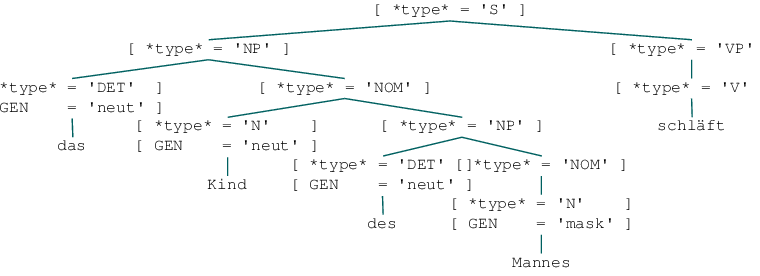

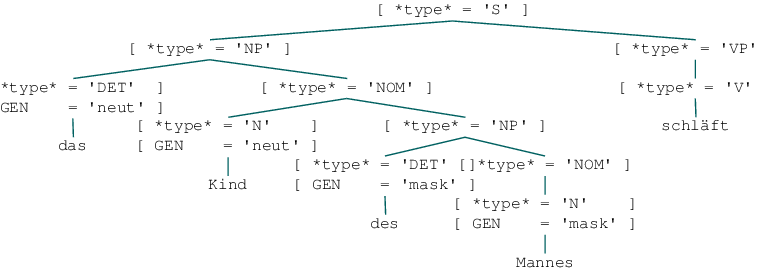

In [13]:
# from nltk.tree import Tree
for t in parser.parse("das Kind des Mannes schläft".split()):
#     t = Tree.fromstring(str(t).replace(", ",","))
#     t.pretty_print(unicodelines=True)
    display(t)

#### Folgendes sollte leer sein:

In [ ]:
list(parser.parse("des Mannes schläft".split()))

---
# Hausaufgaben

---
## Aufgabe 3: Unifikation II

#### Es seien wieder die Merkmalstrukturen aus Aufgabe 1 gegeben.


### 3a) Unifizieren f1 und f4? Gegeben Sie ggf. das Ergebnis an.

In [15]:
print(f1)

[ Nachname = 'Mustermann'                         ]
[                                                 ]
[            [ Ort     = [ Stadt = 'Muenchen' ] ] ]
[ Privat   = [                                  ] ]
[            [ Strasse = 'Hauptstrasse'         ] ]
[                                                 ]
[ Vorname  = 'Max'                                ]


In [16]:
print(f4)

[          [ Ort     = [ Stadt = 'Passau' ] ] ]
[ Privat = [                                ] ]
[          [ Strasse = 'Hauptstrasse'       ] ]


In [ ]:
#### Mit der Ausführung des print-Statements können Sie abschließend die Lösung einsehen:
print(f1.unify(f4))

### 3b) Unifizieren f2 und f3? Gegeben Sie ggf. das Ergebnis an.


In [18]:
print(f2)

[          [ Ort     = (1) [ Stadt = 'Muenchen' ] ] ]
[ Arbeit = [                                      ] ]
[          [ Strasse = 'Oettingenstrasse'         ] ]
[                                                   ]
[ Privat = [ Ort -> (1) ]                           ]


In [19]:
print(f3)

[ Strasse = 'Hauptstrasse' ]


In [ ]:
#### Mit der Ausführung des print-Statements können Sie abschließend die Lösung einsehen:
print(f2.unify(f3))

---
## Aufgabe 4: Weniger Redundanz dank besonderer Merkmale

#### Beseitigen Sie die Redundanz in den lexikalischen Regeln (Zeilen 8 - 32) der folgenden Grammatik durch eine Typhierarchie (wo dies nötig ist). Achten Sie darauf, die Menge der akzeptierten Sätze weder zu verkleinern noch zu vergrößern!

#### Anzugeben sind die neuen Grammatikregeln, sowie Ihre Typhierarchie (z. B. in graphischer Form).

In [21]:
redundant_grammar = """
S -> NP[KAS=nom] VP

NP[KAS=?y] -> DET[GEN=?x,KAS=?y] NOM[GEN=?x,KAS=?y]
NOM[GEN=?x,KAS=?y] -> N[GEN=?x,KAS=?y] NP[KAS=gen]
NOM[GEN=?x,KAS=?y] -> N[GEN=?x,KAS=?y]

DET[GEN=mask,KAS=nom] -> "der"
DET[GEN=mask,KAS=gen] -> "des"
DET[GEN=mask,KAS=dat] -> "dem"
DET[GEN=mask,KAS=akk] -> "den"
DET[GEN=fem,KAS=nom] -> "die"
DET[GEN=fem,KAS=gen] -> "der"
DET[GEN=fem,KAS=dat] -> "der"
DET[GEN=fem,KAS=akk] -> "die"
DET[GEN=neut,KAS=nom] -> "das"
DET[GEN=neut,KAS=gen] -> "des"
DET[GEN=neut,KAS=dat] -> "dem"
DET[GEN=neut,KAS=akk] -> "das"

N[GEN=mask,KAS=nom] -> "Mann"
N[GEN=mask,KAS=gen] -> "Mannes"
N[GEN=mask,KAS=dat] -> "Mann"
N[GEN=mask,KAS=akk] -> "Mann"
N[GEN=fem,KAS=nom] -> "Frau"
N[GEN=fem,KAS=gen] -> "Frau"
N[GEN=fem,KAS=dat] -> "Frau"
N[GEN=fem,KAS=akk] -> "Frau"
N[GEN=neut,KAS=nom] -> "Buch"
N[GEN=neut,KAS=gen] -> "Buches"
N[GEN=neut,KAS=dat] -> "Buch"
N[GEN=neut,KAS=akk] -> "Buch"

VP -> V NP[KAS=dat] NP[KAS=akk]
V -> "gibt" | "schenkt"
"""

In [22]:
pos_sentences = [
    "der Mann gibt der Frau das Buch",
    "die Frau des Mannes gibt dem Mann der Frau das Buch des Buches"
]

#### Testen Sie mit Ihren eigenen Negativbeispielen!

In [23]:
neg_sentences = [
    
]

In [24]:
from IPython.display import display

def test_grammar(grammar, sentences):
    cfg = nltk.grammar.FeatureGrammar.fromstring(grammar)
    parser = nltk.parse.FeatureEarleyChartParser(cfg)
    
    for i, sent in enumerate(sentences, 1):
        print("Satz {}: {}".format(i, sent))
        results = parser.parse(sent.split())
        analyzed = False
        for tree in results:
            print(tree)  # oder display(tree)
            analyzed = True
        if not analyzed:
            print("Keine Analyse möglich", file=sys.stderr)

In [ ]:
test_grammar(redundant_grammar, pos_sentences)